In [1]:
%matplotlib inline
import os
import sys
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.preprocessing import normalize


pd.set_option('display.max_colwidth', -1)
pd.set_option('display.colheader_justify', 'left')
from IPython.display import display, HTML

/Users/dingran/anaconda/envs/carnd-term1/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
new_df = pd.read_pickle('new_df.pkl')
df2 = pd.read_pickle('df2.pkl')

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords
token_pattern = re.compile(r"(?u)\b\w\w+\b")
stop_list=stopwords.words('english') + ['le', 'within', 'hour', 'free', 'using', 'found', 'fact', 'day', 'tag', 'tagged', 'occur']
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in token_pattern.findall(doc)]

# Method1: direct TFIDF, take top N words for each category

In [4]:
cuisine_types = new_df['CUISINE DESCRIPTION'].unique()
food_violation_text = dict()
for c in cuisine_types:
    food_violation_text[c] = ' '.join(new_df[new_df['CUISINE DESCRIPTION']==c]['violation_description'].values)
food_violation_text = pd.Series(food_violation_text)

In [5]:
tfidf_vectorizer = TfidfVectorizer(max_df=50, min_df=2,
                                   max_features=1000,
                                   tokenizer=LemmaTokenizer(),
                                   stop_words=stop_list,
                                   ngram_range=(1, 1))
tfidf = tfidf_vectorizer.fit_transform(food_violation_text)

In [6]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [7]:
len(tfidf_feature_names)

101

In [8]:
#food_violation_text.iloc[0]

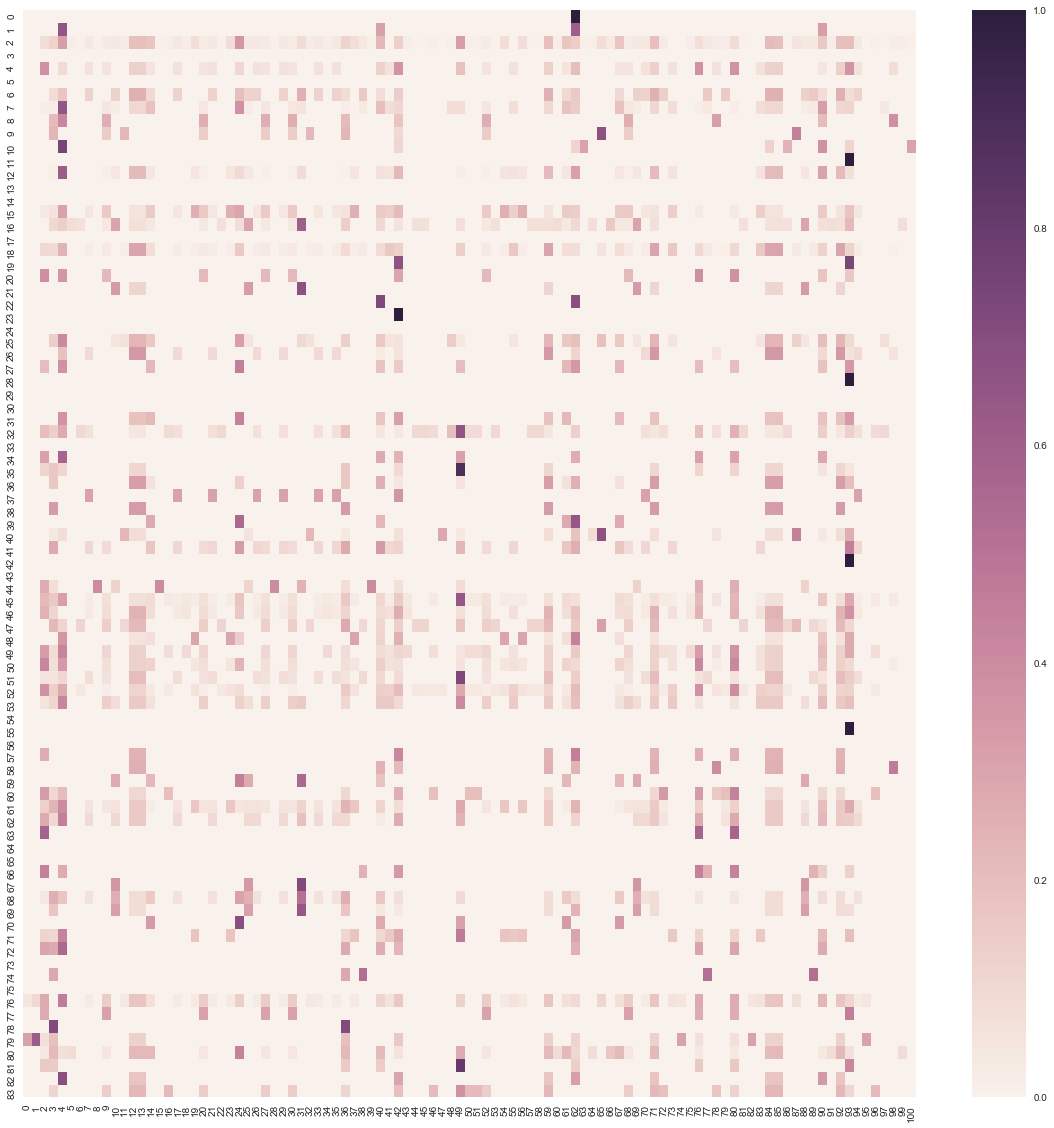

In [9]:
dense = tfidf.todense()
plt.figure(figsize=(20,20))
sns.heatmap(dense)

In [10]:
keyword_method1 = dict()
for i in range(len(cuisine_types)):
    topN = 10
    a = dense[i].argsort()
    a = np.asarray(a)
    keyword_method1[cuisine_types[i]]=[tfidf_feature_names[x] for x in a[0][::-1][:topN]]
keyword_method1 = pd.DataFrame(keyword_method1)

In [11]:
display(keyword_method1[keyword_method1.columns[::15]])

,Afghan,Caribbean,Ethiopian,Italian,Peruvian,Southwestern
0,animal,animal,sneezing,heated,workplace,ambient
1,minimum,tank,thoroughly,commercial,ingredient,ingredient
2,toxic,workplace,otherwise,precooked,exposed,workplace
3,patron,policy,coughing,supposed,gas,interfered
4,ingredient,sold,contaminating,establishment,grade,gas
5,ambient,smoking,ingredient,toxic,handle,grade
6,tank,toxic,preparing,poultry,harmful,handle
7,interfered,patron,ambient,ingredient,heated,harmful
8,department,located,smoking,animal,ice,heated
9,duty,ill,living,ambient,ill,ice


# Method2: First classify violations into topics, manually assign topic keywords, then assign topics to aggregated violation text (per cuisine type) 

In [12]:
tfidf_vectorizer2 = TfidfVectorizer(max_df=.9, min_df=2,
                                    max_features=1000,
                                    tokenizer=LemmaTokenizer(),
                                    stop_words=stop_list)
tfidf2 = tfidf_vectorizer2.fit_transform(df2['VIOLATION DESCRIPTION'])

In [13]:
tfidf_feature_names2 = tfidf_vectorizer2.get_feature_names()

In [14]:
def print_top_words(model, feature_names, n_top_words=20):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
def plot_top_words(model, feature_names, topic_idx, n_top_words=10):
#     for topic_idx, topic in enumerate(model.components_):
    topic=normalize(model.components_[topic_idx].reshape(1,-1))[0]
    sorted_idx=topic.argsort()[:-n_top_words - 1:-1]
    print("Topic #%d:" % topic_idx)
    features=[feature_names[i] for i in sorted_idx]
    print(" ".join(features))
    ax = sns.barplot(x=np.arange(0, 10),y=topic[sorted_idx])
    feature_id=0
    height= max(topic[sorted_idx])*0.6

    for p in ax.patches:
        ax.text(p.get_x()+0.15, height-0.1, '{}'.format(features[feature_id]))
        feature_id+=1
        
Ntopics = 20

In [15]:
nmf = NMF(n_components=Ntopics, random_state=1, alpha=.1, l1_ratio=.2, max_iter=100).fit(tfidf2)
topic_feature=nmf.transform(tfidf2)
topic_feature_norm=normalize(topic_feature)

In [16]:
print(topic_feature.shape)
print(nmf.components_.shape)

(373708, 20)
(20, 362)


Topic #0:
improperly surface contact non unacceptable material side sealed raised allow
Topic #1:
vermin proof attracting conducive condition exist harborage allowing premise facility
Topic #2:
âºf 38 smoked necessary oxygen packaged fish except cold 41âº
Topic #3:
mouse evidence live present food area facility non rat animal
Topic #4:
potential protected display transportation source storage service contamination preparation food
Topic #5:
occurred activity rinsed following washed may sanitized use contamination surface
Topic #6:
properly disposal drained floor siphonage anti backflow functioning prevention plumbing
Topic #7:
fly associated house filth refuse include sewage food blow bottle
Topic #8:
140âº hot item held food refrigerated accurate holding dispensed reused
Topic #9:
utensil dispensing including stored sanitized use improperly used equipment food
Topic #10:
contaminated plan haccp adulterated discarded cross raw cooked accordance prepared
Topic #11:
cloth wiping solution

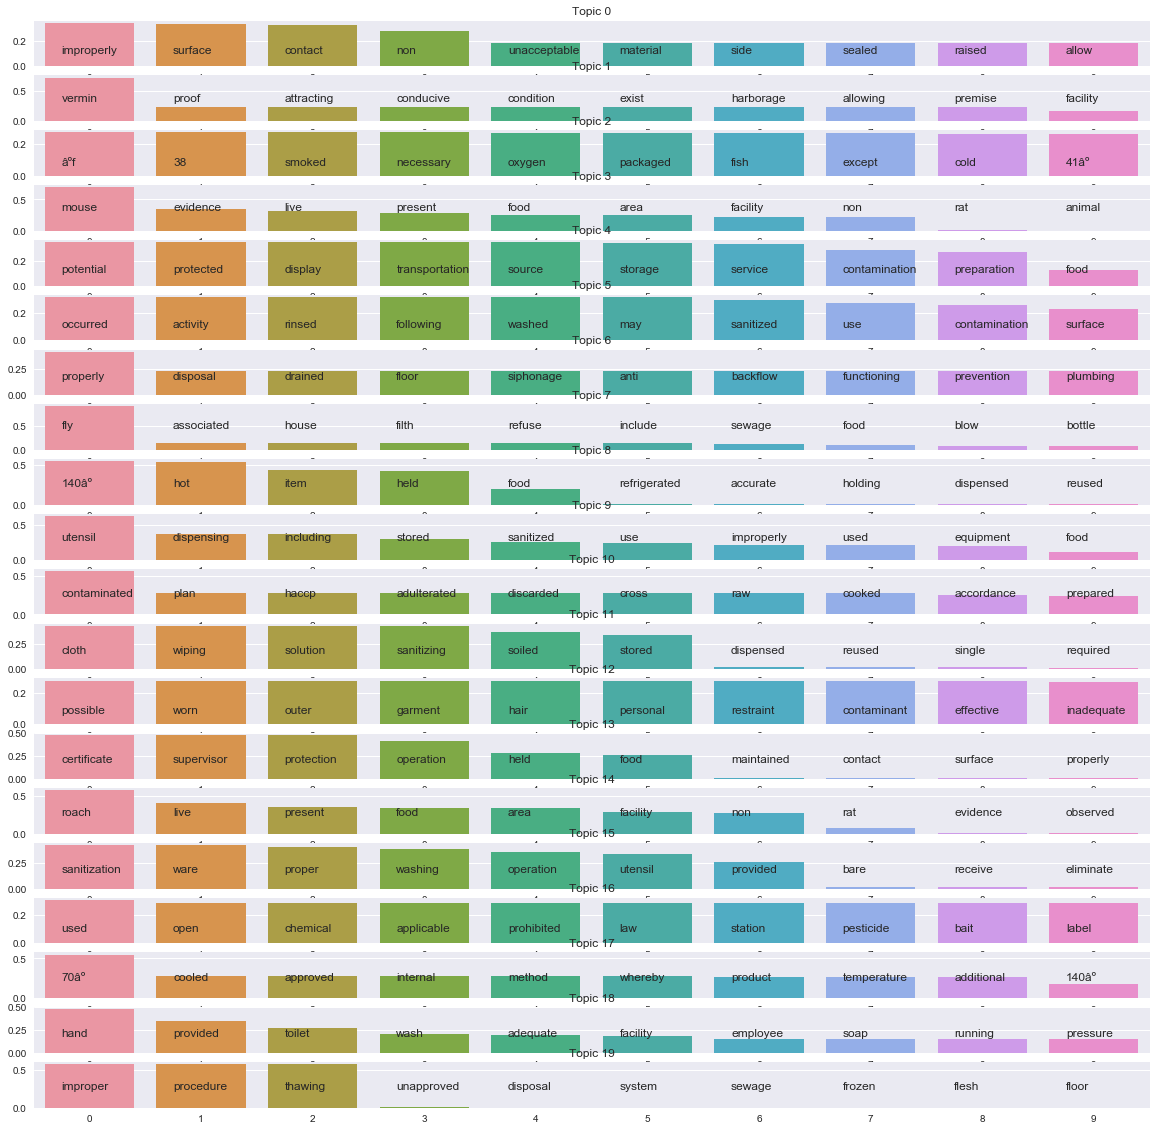

In [17]:
# plot the topics 
fig=plt.figure(figsize=(Ntopics,20))
for i in range(Ntopics):
    plt.subplot(Ntopics,1,i+1)
    plt.title('Topic ' + str(i))
    plot_top_words(nmf,tfidf_feature_names2,i)

In [18]:
# Topic #0:
# improperly surface contact non unacceptable material side sealed raised allow
# Topic #1:
# vermin proof attracting conducive condition exist harborage allowing premise facility
# Topic #2:
# âºf 38 smoked necessary oxygen packaged fish except cold 41âº
# Topic #3:
# mouse evidence live present food area facility non rat animal
# Topic #4:
# potential protected display transportation source storage service contamination preparation food
# Topic #5:
# occurred activity rinsed following washed may sanitized use contamination surface
# Topic #6:
# properly disposal drained floor siphonage anti backflow functioning prevention plumbing
# Topic #7:
# fly associated house filth refuse include sewage food blow bottle
# Topic #8:
# 140âº hot item held food refrigerated accurate holding dispensed reused
# Topic #9:
# utensil dispensing including stored sanitized use improperly used equipment food
# Topic #10:
# contaminated plan haccp adulterated discarded cross raw cooked accordance prepared
# Topic #11:
# cloth wiping solution sanitizing soiled stored dispensed reused single required
# Topic #12:
# possible worn outer garment hair personal restraint contaminant effective inadequate
# Topic #13:
# certificate supervisor protection operation held food maintained contact surface properly
# Topic #14:
# roach live present food area facility non rat evidence observed
# Topic #15:
# sanitization ware proper washing operation utensil provided bare receive eliminate
# Topic #16:
# used open chemical applicable prohibited law station pesticide bait label
# Topic #17:
# 70âº cooled approved internal method whereby product temperature additional 140âº
# Topic #18:
# hand provided toilet wash adequate facility employee soap running pressure
# Topic #19:
# improper procedure thawing unapproved disposal system sewage frozen flesh floor

topic_keywords_assignment = dict()
topic_keywords_assignment[0] = 'food contact surface'
topic_keywords_assignment[1] = 'vermin'
topic_keywords_assignment[2] = 'cold food temperature'
topic_keywords_assignment[3] = 'mice'
topic_keywords_assignment[4] = 'food contamination'
topic_keywords_assignment[5] = 'wash and rinse facility'
topic_keywords_assignment[6] = 'plumbing facility'
topic_keywords_assignment[7] = 'flies'
topic_keywords_assignment[8] = 'hot food temperature'
topic_keywords_assignment[9] = 'utensil handling'
topic_keywords_assignment[10] = 'HACCP'
topic_keywords_assignment[11] = 'wiping cloth'
topic_keywords_assignment[12] = 'garment'
topic_keywords_assignment[13] = 'certificate'
topic_keywords_assignment[14] = 'roach'
topic_keywords_assignment[15] = 'sanitization'
topic_keywords_assignment[16] = 'chemical'
topic_keywords_assignment[17] = 'food cooling'
topic_keywords_assignment[18] = 'hand washing'
topic_keywords_assignment[19] = 'thrawing'

In [19]:
a = df2.reset_index()
topN = 10
keyword_method2 = dict()
for i in range(len(cuisine_types)):
    idx = a[a['CUISINE DESCRIPTION'] == cuisine_types[i]].index
    keyword_method2[cuisine_types[i]]=[topic_keywords_assignment[x] for x in topic_feature[idx].sum(axis=0).argsort()[::-1][:topN]]
keyword_method2 = pd.DataFrame(keyword_method2)

In [20]:
display(keyword_method2)

,Afghan,African,American,Armenian,Asian,Australian,Bagels/Pretzels,Bakery,Bangladeshi,Barbecue,...,Soups & Sandwiches,Southwestern,Spanish,Steak,Tapas,Tex-Mex,Thai,Turkish,Vegetarian,Vietnamese/Cambodian/Malaysia
0,food contact surface,vermin,food contact surface,food contact surface,food contact surface,vermin,food contact surface,food contact surface,food contact surface,food contact surface,...,food contact surface,food contact surface,food contact surface,food contact surface,food contact surface,food contact surface,food contact surface,food contact surface,food contact surface,food contact surface
1,vermin,flies,vermin,vermin,vermin,food contact surface,vermin,vermin,hot food temperature,vermin,...,cold food temperature,vermin,vermin,plumbing facility,vermin,vermin,vermin,vermin,vermin,vermin
2,mice,hot food temperature,wash and rinse facility,wash and rinse facility,hot food temperature,mice,cold food temperature,mice,vermin,hot food temperature,...,flies,flies,hot food temperature,wash and rinse facility,food contamination,mice,cold food temperature,mice,mice,food contamination
3,plumbing facility,food contact surface,plumbing facility,flies,food contamination,plumbing facility,mice,food contamination,mice,flies,...,plumbing facility,hot food temperature,mice,vermin,plumbing facility,hot food temperature,mice,plumbing facility,food contamination,cold food temperature
4,wash and rinse facility,mice,mice,mice,mice,cold food temperature,food contamination,hot food temperature,roach,plumbing facility,...,vermin,mice,flies,cold food temperature,wash and rinse facility,plumbing facility,food contamination,food contamination,plumbing facility,hot food temperature
5,food contamination,food contamination,food contamination,plumbing facility,wash and rinse facility,flies,wash and rinse facility,flies,cold food temperature,wash and rinse facility,...,wash and rinse facility,plumbing facility,plumbing facility,hot food temperature,flies,flies,roach,wash and rinse facility,hot food temperature,mice
6,flies,plumbing facility,flies,food contamination,cold food temperature,food contamination,flies,plumbing facility,flies,cold food temperature,...,food contamination,cold food temperature,food contamination,food contamination,mice,food contamination,hot food temperature,flies,cold food temperature,wash and rinse facility
7,roach,certificate,cold food temperature,HACCP,plumbing facility,wash and rinse facility,plumbing facility,roach,food contamination,mice,...,mice,garment,cold food temperature,mice,cold food temperature,cold food temperature,wash and rinse facility,cold food temperature,flies,roach
8,HACCP,roach,HACCP,cold food temperature,flies,HACCP,hot food temperature,wash and rinse facility,plumbing facility,food contamination,...,hot food temperature,wash and rinse facility,wash and rinse facility,HACCP,HACCP,wash and rinse facility,plumbing facility,hot food temperature,wash and rinse facility,plumbing facility
9,garment,cold food temperature,hot food temperature,certificate,roach,chemical,roach,cold food temperature,certificate,HACCP,...,utensil handling,food contamination,roach,flies,hand washing,roach,flies,roach,utensil handling,utensil handling


In [21]:
display(keyword_method2[keyword_method2.columns[::15]])

,Afghan,Caribbean,Ethiopian,Italian,Peruvian,Southwestern
0,food contact surface,vermin,food contact surface,food contact surface,vermin,food contact surface
1,vermin,mice,vermin,vermin,mice,vermin
2,mice,food contact surface,mice,wash and rinse facility,food contact surface,flies
3,plumbing facility,hot food temperature,food contamination,plumbing facility,food contamination,hot food temperature
4,wash and rinse facility,flies,plumbing facility,mice,plumbing facility,mice
5,food contamination,plumbing facility,wash and rinse facility,food contamination,hot food temperature,plumbing facility
6,flies,roach,sanitization,cold food temperature,flies,cold food temperature
7,roach,food contamination,flies,flies,wash and rinse facility,garment
8,HACCP,cold food temperature,certificate,hot food temperature,cold food temperature,wash and rinse facility
9,garment,food cooling,hand washing,HACCP,roach,food contamination
